(50000,)
12068
(50000,)
11899
(50000,)
11898
(50000,)
11889
(50000,)
11874


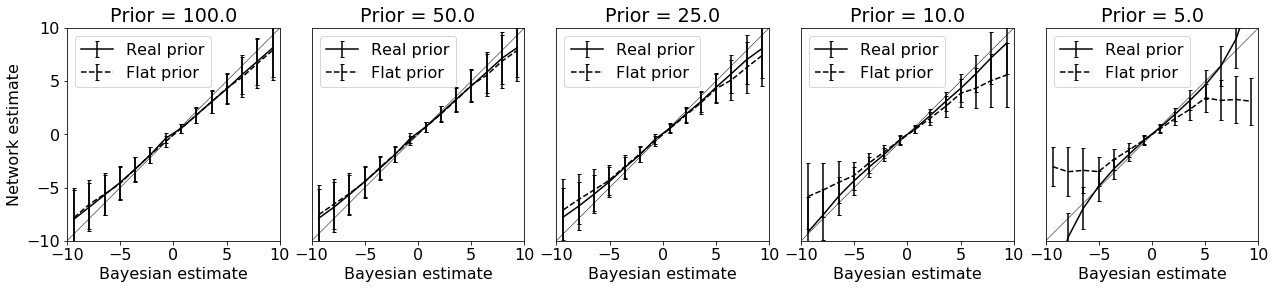

In [27]:
import sys
sys.path.append("/home/squax/GitHub/PNN/")
import torch
import numpy as np
import tqdm
import json

import matplotlib.pyplot as plt
import scipy.stats as sst

from tasks import *
from pytorch_networks import *
from tools import *
from pytorch_trainer import *

plt.rcParams.update({'font.size': 16})
#     params['n_epochs'] = 50
#     params['N_input'] = 50
#     params['N_hidden'] = 200
#     params['N_train'] = 100000
#     params['N_test'] = 20000
#     params['N_cond'] = 1

#     # data parameters
#     params['mean']=0.0
#     params['sigma']=priors[ii]
#     params['sig_phi']=10.0
#     params['gain']=(np.array([0.37,0.90,1.81,2.82,3.57,4.00])*0.8).tolist()#[0.37,0.90,1.81,2.82,3.57,4.00]*0.4 #*0.4
predictors = []
Qs = []
priors = []
tests = []

for task_id in xrange(1,6):
    task = 'con_'+str(task_id)

    param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_GNH204_rev' + task
    model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_GNH204_rev' + task
#     param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_GNH0' + task
#     model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_GNH0' + task    
#     param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_GNH200_' + task
#     model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_GNH200_' + task
    
    with open(param_loc+'.json','r') as fp:
        params = json.load(fp)   
    locals().update(params)
    N_test = 50000

    priors.append(sigma)
    
    # define task
#     train_data = continuous_task_TG(n_samples=N_train, n_input=N_input, sig2N=sig_phi, muP=mean, sig2P=sigma, g=gain, test=False)
    test_data = continuous_task2(n_samples=N_test, n_input=N_input, sig2N=sig_phi, muP=mean, sig2P=sigma, g=gain, test=False)

    # define data iterators
#     train_iter = RandomIterator(train_data, batch_size=10)
    test_iter = FixedIterator(test_data, batch_size=N_test*len(gain)*N_cond)

    # define model
    # model = Classifier(MLP(N_hidden, 2, no_bias = True))
    model = Regressor(MLP_nobias(N_input,N_hidden, 1, bias = False))

    # Setup an optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0002,weight_decay=0)

    # load model
    model.load_state_dict(torch.load(model_loc))
    model.eval()

    #model.predictor.l2.b.data[[0,1]]=model.predictor.l2.b.data[[1,0]]

    # setup tester
    test = tester(model)

    # run tester
    test.run(test_iter)
    
    predictors.append(model.predictor)
    tests.append(test)
    
    # extract relevant data
    Q = extract_quantities(test,gain,N_test,N_cond)
    print(np.sum(test.R,1)[np.squeeze(test.G==gain[0])].shape)
    print(len(test.R)/6-np.count_nonzero(np.sum(test.R,1)[np.squeeze(test.G==gain[0])]))
    
    idxg = np.in1d(np.squeeze(test.G),gain)
#     test.test_posterior[test.test_posterior[:,0]>20,0]=20
#     test.test_posterior[test.test_posterior[:,0]<-20,0]=-20
    Qs.append(Q)
#     HP11=bin_plot(test.C[idxg,0],test.test_posterior[idxg,0],bin_lim = [-10,10],sem=False)
#     HP21=bin_plot(test.C[idxg,0],test.real_posterior[idxg],bin_lim = [-10,10],sem=False)
# #     HP11=bin_plot(test.real_posterior[idxg],test.test_posterior[idxg,0],bin_lim = [-20,20],sem=False)
# #     HP21=bin_plot(test.real_posterior2[idxg],test.test_posterior[idxg,0],bin_lim = [-20,20],sem=False)
    
#     plt.figure(1,figsize = (18,4))
#     plt.subplot(1,5,task_id)
#     plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Network',capsize=2)
#     plt.errorbar(HP21['bins'],HP21['post_mean'],HP21['post_std'],fmt='k--', label = 'Bayesian model',capsize=2)
#     plt.plot([-20,20],[-20,20],'k',linewidth=0.5)
#     ax=plt.gca()
#     ax.set_aspect(1)
#     plt.xlim(-10,10)
#     plt.ylim(-10,10)
#     plt.title('Prior = '+str(sigma))
#     plt.xlabel('Stimulus')
# #     plt.xticks([0,0.5,1])
#     plt.legend()
#     if task_id == 1:
#         plt.ylabel('Estimate')
#     else:
#         plt.yticks([])
        
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.15)

    HP11=bin_plot(test.real_posterior[idxg],test.test_posterior[idxg,0],bin_lim = [-10,10],sem=False)
    HP21=bin_plot(test.real_posterior2[idxg],test.test_posterior[idxg,0],bin_lim = [-10,10],sem=False)
    
    fig2 = plt.figure(2,figsize = (18,4))
    plt.subplot(1,5,task_id)
    plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Real prior',capsize=2)
    plt.errorbar(HP21['bins'],HP21['post_mean'],HP21['post_std'],fmt='k--', label = 'Flat prior',capsize=2)
    plt.plot([-20,20],[-20,20],'k',linewidth=0.5)
    ax=plt.gca()
    ax.set_aspect(1)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.title('Prior = '+str(sigma))
    plt.xlabel('Bayesian estimate')
#     plt.xticks([0,0.5,1])
    plt.legend()
    if task_id == 1:
        plt.ylabel('Network estimate')
    else:
        plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/real_vs_flat_con2_nohid_rev.eps',format='eps')
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/owl2.eps',format='eps')


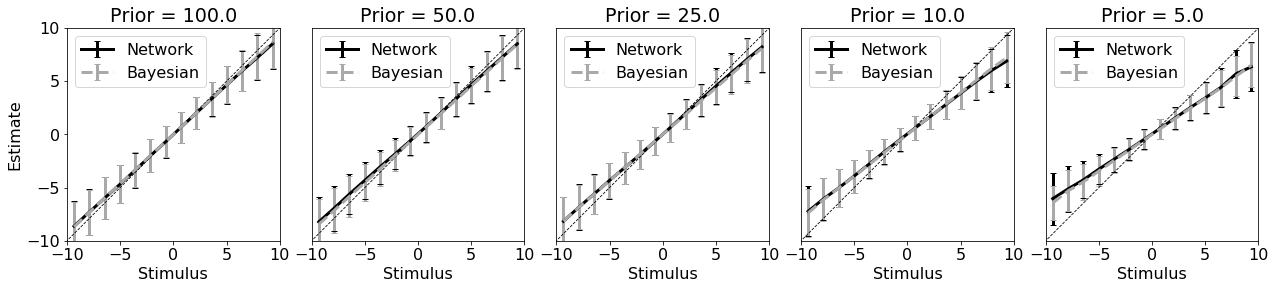

In [16]:
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/real_vs_flat_con.eps',format='eps')
for ii in xrange(5):
    HP11=bin_plot(tests[ii].C[idxg,0],tests[ii].test_posterior[idxg,0],bin_lim = [-10,10],sem=False)
    HP21=bin_plot(tests[ii].C[idxg,0],tests[ii].real_posterior[idxg],bin_lim = [-10,10],sem=False)
#     HP11=bin_plot(test.real_posterior[idxg],test.test_posterior[idxg,0],bin_lim = [-20,20],sem=False)
#     HP21=bin_plot(test.real_posterior2[idxg],test.test_posterior[idxg,0],bin_lim = [-20,20],sem=False)
    
    plt.figure(1,figsize = (18,4))
    plt.subplot(1,5,ii+1)
    plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],color='k',label ='Network',linewidth=3,capsize=3)
    plt.errorbar(HP21['bins'],HP21['post_mean'],HP21['post_std'],fmt='--',color='darkgrey',linewidth=3, label = 'Bayesian',capsize=3)
    plt.plot([-20,20],[-20,20],'--k',linewidth=0.8)
    ax=plt.gca()
    ax.set_aspect(1)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.title('Prior = '+str(priors[ii]))
    plt.xlabel('Stimulus')
#     plt.xticks([0,0.5,1])
    plt.legend()
    if ii+1 == 1:
        plt.ylabel('Estimate')
    else:
        plt.yticks([])
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
#plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/owl2_rev.eps',format='eps')



18.858612
9.662522
5.1697383
2.607271
1.6758024


(0, 47)

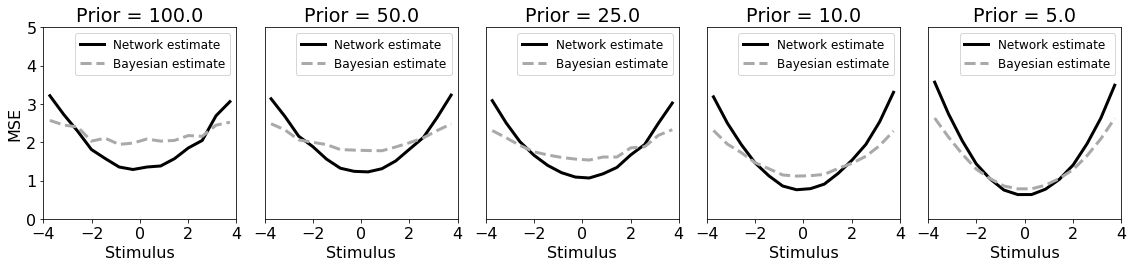

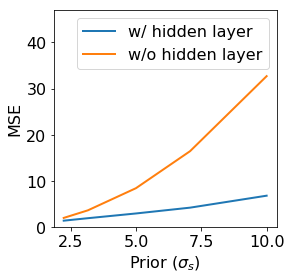

In [26]:
plt.figure(1,figsize = (16,4))

for ii in xrange(0,5):
    idxg = np.in1d(np.squeeze(test.G),gain)
    targets = tests[ii].C[idxg,0]
    y = tests[ii].test_posterior[idxg,0]
    y2 = tests[ii].real_posterior[idxg]


    errors = (y-targets)**2
    errors2 = (y2-targets)**2

    print(np.mean(errors))
#     print(np.corrcoef(tests[ii].test_posterior[:,0],tests[ii].real_posterior))

    HP11=bin_plot(targets,errors,bin_lim = [-4,4],sem=False)
    HP12=bin_plot(targets,errors2,bin_lim = [-4,4],sem=False)

    plt.subplot(1,5,ii+1)
    plt.plot(HP11['bins'],HP11['post_mean'],'k',linewidth=3)
    plt.plot(HP12['bins'],HP12['post_mean'],'--',color='darkgrey',linewidth=3)

#     plt.plot([-20,20],[-20,20],'k',linewidth=0.5)
    ax=plt.gca()
#     ax.set_aspect(1)
    plt.xlim(-4,4)
    plt.ylim(0,5)
    plt.title('Prior = '+str(priors[ii]))
    plt.xlabel('Stimulus')
#     plt.xticks([0,0.5,1])
#     plt.ylim([])
    plt.legend(['Network estimate','Bayesian estimate'],fontsize=12)
#     if ii == 0:
    if ii==0:
        plt.ylabel('MSE')

    else:
        plt.yticks([])

plt.tight_layout()
#plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/error_vs_stim_rev.eps',format='eps')

errors_hid_vs_nohid = np.array([[6.854907,4.2689524,3.011848,1.9892144,1.4555128],[32.692326,16.478415,8.475866,3.69249,2.0496652]])
plt.figure(figsize = (4,4))
plt.plot(np.sqrt(priors),errors_hid_vs_nohid.T,'-',linewidth=2)
plt.xlabel(r'Prior ($\sigma_s$)')
plt.ylabel('MSE')
plt.legend(['w/ hidden layer','w/o hidden layer'])
plt.ylim([0,47])
#plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/error_hid_vs_nohid_rev.eps',format='eps')


[0.296, 0.7200000000000001, 1.4480000000000002, 2.256, 2.856, 3.2]
[0.296, 0.7200000000000001, 1.4480000000000002, 2.256, 2.856, 3.2]


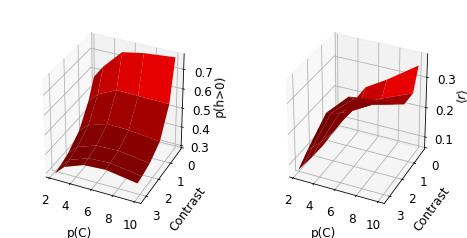

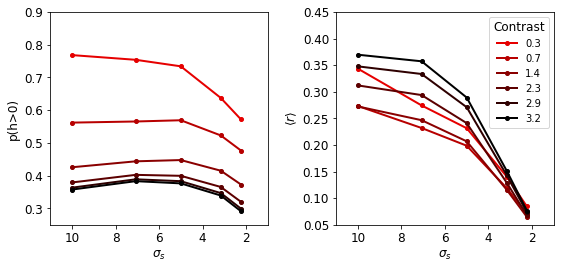

In [108]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,3))

from matplotlib import rc
rc('font', family='sans-serif') 
rc('font', serif='Arial') 
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

dist=11
ver,hor = 30,115

# plt.figure(figsize=(15,3.8))
fig = plt.figure(1,figsize=(8,4))

#     idx = ((tests[ii].C > -np.sqrt(priors[ii])) & (tests[ii].C < np.sqrt(priors[ii])))[:,0]
#     print(idx.shape)
#     N_hidden = tests[ii].H.shape[1]
#     N_nonzero = np.mean(np.count_nonzero(tests[ii].H[idx,:],axis=1))/N_hidden
#     N_nonzero2 = np.mean(np.count_nonzero(tests[ii].H[~idx,:],axis=1))/N_hidden
#     print(N_nonzero)
#     print(N_nonzero2)
ax = fig.add_subplot(121,projection='3d')
mean1 = np.zeros((5,6))
for ii in xrange(5):
    mean1[ii,:] = Qs[ii]['sparseness'][:,0]

#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.array(np.sqrt([100,50,25,10,5]))
Y = gain
print(Y)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

ax.plot_surface(X,Y,mean1.T)
ax.set_xlabel('p(C)')
ax.set_ylabel('Contrast')
ax.set_zlabel('p(h>0)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.tick_params(axis='z',pad=8)
ax.set_yticks([0.0,1.0,2.0,3.0])
ax.invert_xaxis()

ax.view_init(ver, hor)
ax.dist = dist

ax = fig.add_subplot(122,projection='3d')
mean1 = np.zeros((5,6))
for ii in xrange(5):
    mean1[ii,:] = Qs[ii]['H_mean']

#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.array(np.sqrt([100,50,25,10,5]))
Y = gain
print(Y)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

ax.plot_surface(X,Y,mean1.T)
ax.set_xlabel('p(C)')
ax.set_ylabel('Contrast')
ax.set_zlabel(r'$\langle r \rangle$')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.tick_params(axis='z',pad=8)
ax.set_yticks([0.0,1.0,2.0,3.0])
ax.invert_xaxis()

ax.view_init(ver, hor)
ax.dist = dist

#########################
plt.rcParams.update({'font.size': 12})

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams, cycler

cm = LinearSegmentedColormap.from_list(
        'my_list', [(0.9,0,0),(0,0,0)], N=6)
cmap = cm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0,1,6)))

fig = plt.figure(2,figsize=(8,3.9))

mean1 = np.zeros((5,6))
ax = fig.add_subplot(121)
for ii in xrange(0,5):
    mean1[ii,:]=Qs[ii]['sparseness'][:,0]
#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.array(np.sqrt([100,50,25,10,5]))
Y = gain

img2 = ax.plot(X,mean1,'.-',linewidth=2,markersize=8)
ax.set_xlabel(r'$\sigma_s$')
ax.set_ylabel('p(h>0)')
plt.xlim([1,11])
ax.invert_xaxis()

plt.ylim([0.25,0.9])

mean1 = np.zeros((5,6))
ax = fig.add_subplot(122)
for ii in xrange(0,5):
    mean1[ii,:]=Qs[ii]['H_mean']
#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.array(np.sqrt([100,50,25,10,5]))
Y = gain

img2 = ax.plot(X,mean1,'.-',linewidth=2,markersize=8)
ax.set_xlabel(r'$\sigma_s$')
ax.set_ylabel(r'$\langle r \rangle$')
plt.xlim([1,11])

ax.invert_xaxis()
plt.ylim([0.05,0.45])
leg = plt.legend(["%.1f" % gain[0],"%.1f" % gain[1],"%.1f" % gain[2],"%.1f" % gain[3],"%.1f" % gain[4],"%.1f" % gain[5]],prop={'size':10})
leg.set_title('Contrast')

plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/continuous/Activation_effect_con.eps',format='eps')

# #     plt.plot(Qs[ii]['sparseness'][:,0],color = 'k')
# plt.errorbar(gain,Qs[ii]['sparseness'][:,0],Qs[ii]['sparseness'][:,1],capsize=3,color = 'k')
# #     plt.plot(gain,Qs[ii]['sparseness'][:,0],color = 'k')

# plt.xlabel('Gain')
# plt.title('Prior ' + r'$\sigma$' +' = '+str(priors[ii]))
# plt.ylim([0.25,0.85])


# if ii==0:
#     plt.ylabel('P(h>0)')

# else:
#     plt.yticks([])
# plt.tight_layout()
#     plt.savefig('/vol/ccnlab1/silqua/prirep/figures/continuous/Sparse_vs_prior.eps',format='eps')



#     plt.figure(2,figsize = (12,4))
#     HP11=bin_plot(tests[ii].C[:,0],1.0*np.count_nonzero(tests[ii].H,axis=1)/N_hidden,bin_lim = [-1,1],sem=False)
# #     HP11=bin_plot(tests[ii].C[:,0],1.0*np.sum(tests[ii].H,axis=1)/N_hidden,bin_lim = [-5,5],sem=False)

#     plt.subplot(1,5,ii+1)
#     plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Network',capsize=2)
# #     plt.ylim([0.2,0.7])

(5, 200)


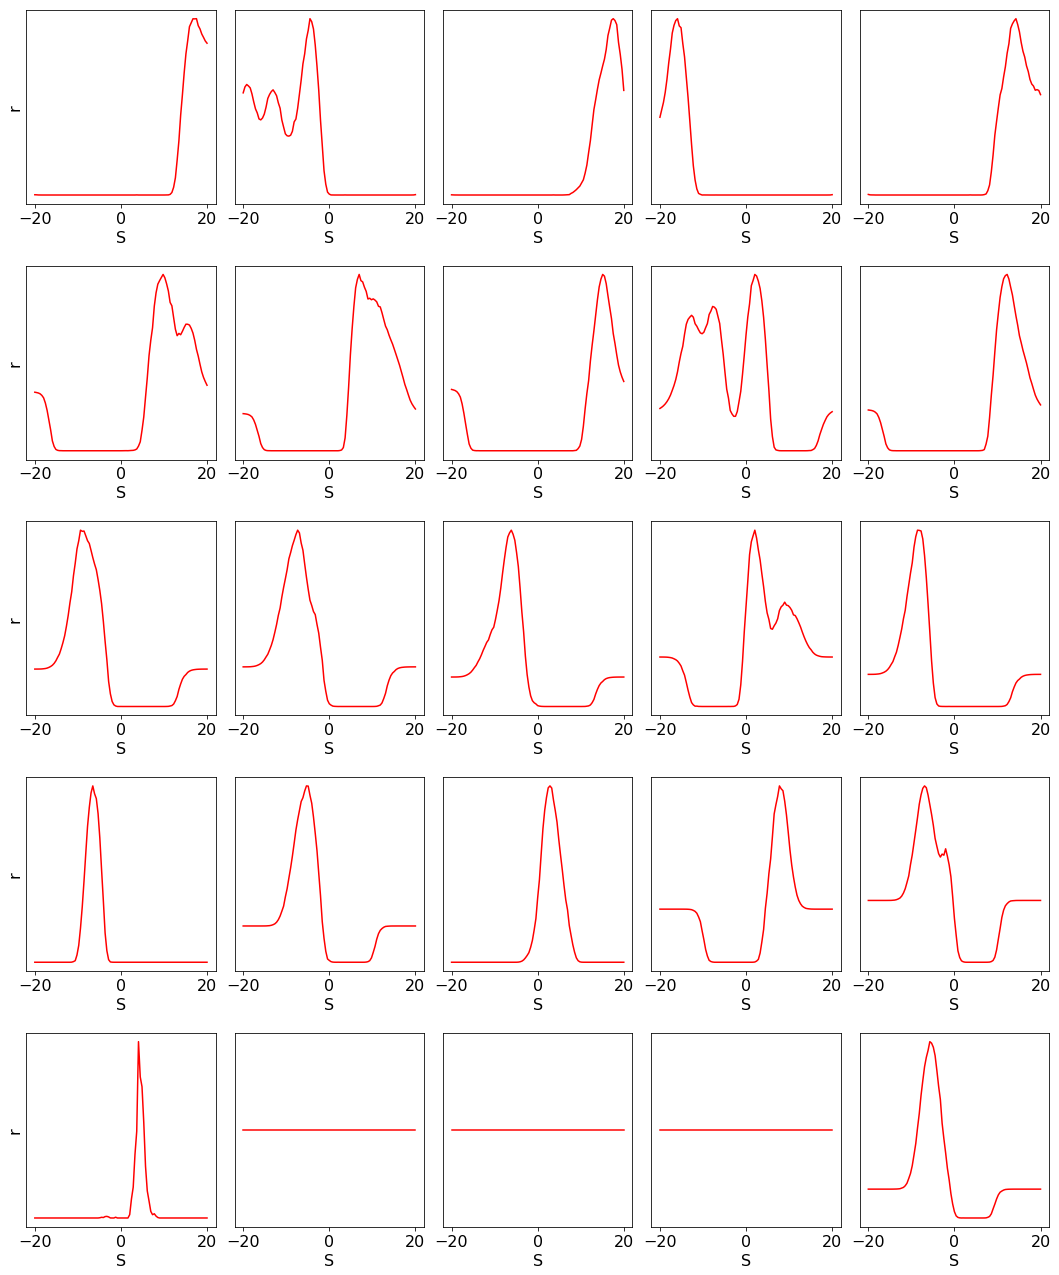

In [24]:
plt.figure(figsize=(15,18));plt.clf;
TC_peak = np.zeros((5,200))
TC_width = np.zeros((5,200))
b = np.zeros((5,200))
g1 = np.zeros((5,200))
W = np.zeros((5,200,50))

for task_id in xrange(1,6):
    task = 'con_'+str(task_id)
    model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_GNH200_2' + task

    #load model
    test_data = continuous_task2(n_samples=N_test, n_input=N_input, sig2N=sig_phi, muP=mean, sig2P=sigma, g=gain, test=True, tuning=True)
    test_iter = FixedIterator(test_data, batch_size=N_test*len(gain)*N_cond)
    model = Regressor(MLP(N_input,N_hidden, 1, bias = False))

    # Setup an optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0002,weight_decay=0)

    # load model
    model.load_state_dict(torch.load(model_loc))
    model.eval()
    
    test = tester(model)
    test.run(test_iter)
    
    b[task_id-1,:] = predictors[task_id-1].l1.bias.data.numpy()
    g1[task_id-1,:] = predictors[task_id-1].p1.data.numpy()
    W[task_id-1,:,:] = predictors[task_id-1].l1.weight.data.numpy()

    TC = tuning_curves(test.H,test.S,test.G,gain,nbin=100,bin_lims=[-40,40])
    TC_peak[task_id-1,:] = np.argmax(np.abs(np.diff(TC[:,:,5],axis=1)), axis = 1)/100.0*80-40
#     TC_peak[task_id-1,:] = np.argmax(TC[:,:,5], axis = 1)/100.0*80-40

    TC_width[task_id-1,:] = FWHM(TC[:,:,5],bin_lims = [-40,40],nbin=100)

    idx = np.argsort(b[task_id-1,:])[:5]
    for ii in xrange(5):
        plt.subplot(5,5,(task_id-1)*5+ii+1)
        #plt.plot(np.linspace(-20,20,99),TC[ii+15,:,2].T,'k')
        plt.plot(np.linspace(-20,20,99),TC[ii+15, :, 5].T,'r')
        plt.xlabel('S')
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.1)
        if  ii == 0:
            plt.ylabel('r')
            plt.yticks([])

        else:
            plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)

plt.savefig('/vol/ccnlab1/silqua/prirep/figures/tuning_curves_gain_rev2.eps',format='eps')
print(TC_peak.shape)


In [12]:
x = np.array([3, 4, 2, 1,5,7,8,9])
np.argpartition(x, 1)
A=np.array([3, 4, 2, 1,5,7,8,9])
B=np.where(A<1)
print(B[0].size)

0


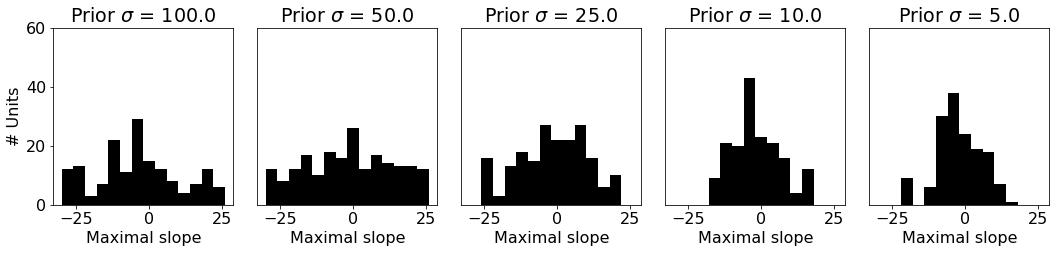

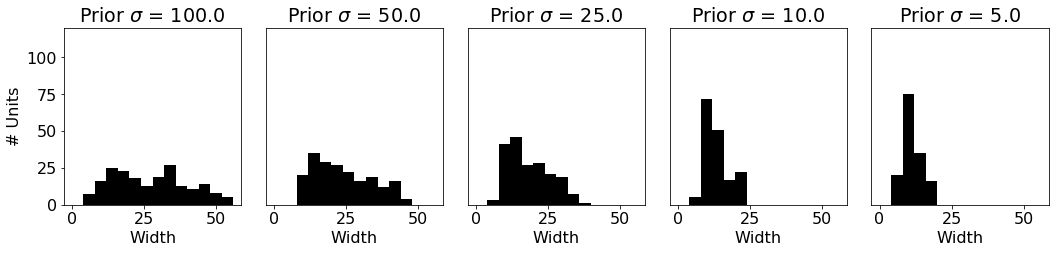

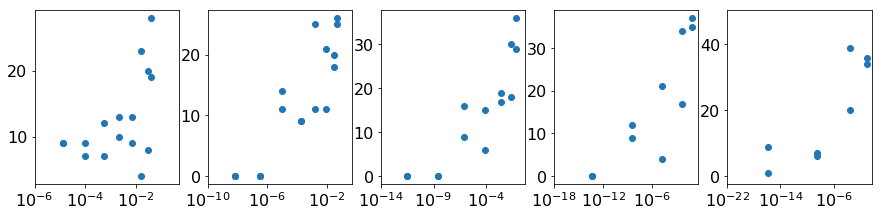

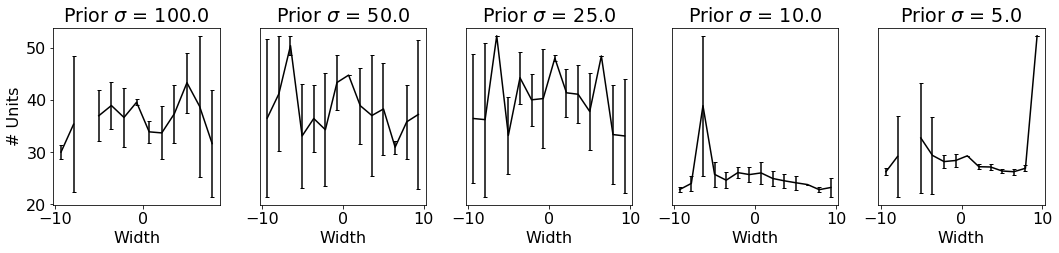

In [45]:
plt.figure(figsize=(15,3.8))
for ii in xrange(5):
    plt.subplot(1,5,ii+1)
    plt.hist(TC_peak[ii,:],bins=np.arange(-30,30,4),facecolor='k')
    plt.ylim([0,60])
    plt.xlabel('Maximal slope')
    plt.title('Prior ' + r'$\sigma$' +' = '+str(priors[ii]))

    if ii==0:
        plt.ylabel('# Units')
    else:
        plt.yticks([])
    plt.tight_layout()
#     plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/Slope_hist.eps',format='eps')

    
plt.figure(figsize=(15,3.8))
for ii in xrange(5):
    plt.subplot(1,5,ii+1)
    plt.hist(TC_width[ii,:],bins=np.arange(0,60,4),facecolor='k')
    plt.ylim([0,120])
    plt.xlabel('Width')
    plt.title('Prior ' + r'$\sigma$' +' = '+str(priors[ii]))
    if ii==0:
        plt.ylabel('# Units')
    else:
        plt.yticks([])
    plt.tight_layout()
#     plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/Width_hist.eps',format='eps')

plt.figure(figsize=(15,3.2))
for ii in xrange(5):
    P = 1.0/np.sqrt(2*np.pi*priors[ii])*np.exp(-(np.linspace(-40,40,16))**2/(2*priors[ii]))
    TC_bin = np.histogram(TC_peak[ii,:],bins=np.arange(-40,45,5))
    plt.subplot(1,5,ii+1)
    plt.scatter(P,TC_bin[0])
    plt.xlim([1*10**-(6+4*ii),0.5])
    plt.xscale('log')

plt.figure(figsize=(15,3.8))
for ii in xrange(5):
    HP11=bin_plot(TC_peak[ii,:],TC_width[ii,:],bin_lim = [-10,10],sem=False)

    plt.subplot(1,5,ii+1)
    plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Real prior',capsize=2)
#     plt.ylim([0,40])
    plt.xlabel('Width')
    plt.title('Prior ' + r'$\sigma$' +' = '+str(priors[ii]))
    if ii==0:
        plt.ylabel('# Units')
    else:
        plt.yticks([])
    plt.tight_layout()

Ttest_indResult(statistic=2.356629283419251, pvalue=0.019418179571682487)
Ttest_indResult(statistic=3.03279668479099, pvalue=0.002747457303553142)
Ttest_indResult(statistic=4.7516516811218965, pvalue=3.8711052607507e-06)
Ttest_indResult(statistic=2.853273204517667, pvalue=0.004787013863922958)
Ttest_indResult(statistic=2.6486438671504464, pvalue=0.008733357364920044)
Ttest_indResult(statistic=-3.153906670427616, pvalue=0.0018618800528456738)
Ttest_indResult(statistic=-1.4694194582021871, pvalue=0.1433061463748381)
Ttest_indResult(statistic=0.7937874010189145, pvalue=0.42826948298347)
Ttest_indResult(statistic=1.1940863362138616, pvalue=0.23387277775589263)
Ttest_indResult(statistic=2.931588176972025, pvalue=0.0037692209229294735)


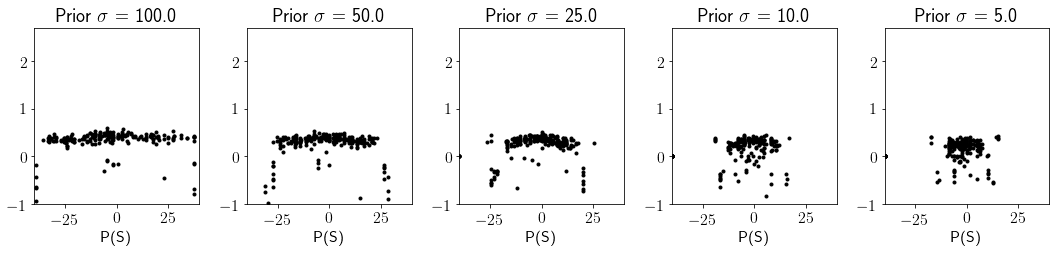

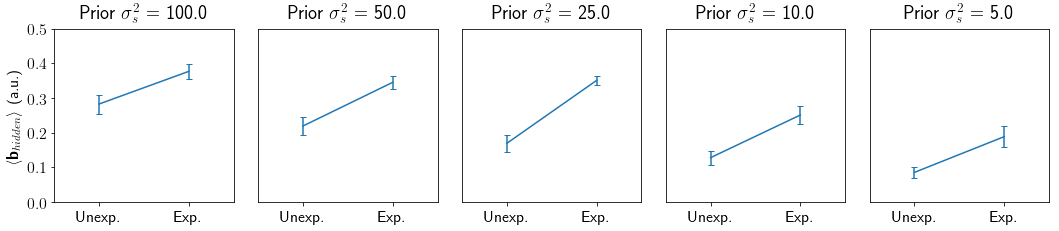

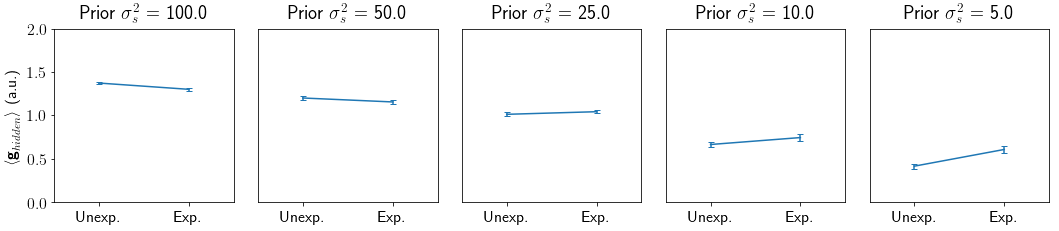

In [135]:
## import scipy.stats as sst
from matplotlib import rc

plt.rcParams.update({'font.size': 16})

rc('text', usetex=True)

plt.figure(figsize=(15,3.8))
for ii in xrange(5):
    P = 1.0/np.sqrt(2*np.pi*priors[ii])*np.exp(-TC_peak[ii,:]**2/(2*priors[ii]))
    plt.subplot(1,5,ii+1)
    plt.plot(TC_peak[ii,:],b[ii,:],'.k')
    plt.xlabel('P(S)')
#     plt.xlim([10e-10,10e-1])
    plt.title('Prior ' + r'$\sigma$' +' = '+str(priors[ii]))
#     plt.xscale('log')
#     if ii==0:
#         plt.ylabel('bias')
#     else:
#         plt.yticks([])
    plt.xlim([-40,40])
    plt.ylim([-1.0,2.7])
    plt.tight_layout()
#     plt.savefig('/vol/ccnlab1/silqua/prirep/figures/continuous/Width_hist.eps',format='eps')print(test.H[:,198])
    [C,p]=sst.pearsonr(P,b[ii,:])


mbias = np.zeros((5,2))
sbias = np.zeros((5,2))
plt.figure(figsize=(15,3.5))
for ii in xrange(5):
    plt.subplot(1,5,ii+1)

    idx = ((TC_peak[ii,:] < np.sqrt(priors[ii])) & (TC_peak[ii,:] > -np.sqrt(priors[ii])))
#     idx2 = ((TC_peak[ii,:] < 2*np.sqrt(priors[ii])) & (TC_peak[ii,:] > -2*np.sqrt(priors[ii])) | (TC_peak[ii,:] > np.sqrt(priors[ii])) & (TC_peak[ii,:] < -np.sqrt(priors[ii])))
    
    mbias[ii,1] = np.mean(b[ii,idx])
    mbias[ii,0] = np.mean(b[ii,~idx])
    sbias[ii,1] = np.std(b[ii,idx])/np.sqrt(np.sum(idx))
    sbias[ii,0] = np.std(b[ii,~idx])/np.sqrt(200-np.sum(idx))
    plt.errorbar([0,1],mbias[ii,:],sbias[ii,:],color = '#1f77b4',capsize=3)
    plt.xlim([-0.5,1.5])
    plt.ylim([0.0,0.5])
    plt.title('Prior ' + r'$\sigma_s^2$' +' = '+str(priors[ii]))
    plt.xticks([0,1],['Unexp.','Exp.'])
    if ii==0:
        plt.ylabel(r'$\langle \textbf{b}_{hidden} \rangle$ (a.u.)')
    else:
        plt.yticks([])
    plt.tight_layout()
    print(sst.ttest_ind(b[ii,idx].flatten(),b[ii,~idx].flatten()))

# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/continuous/bias_vs_prior_con.eps',format='eps')

mgain = np.zeros((5,2))
sgain = np.zeros((5,2))
plt.figure(figsize=(15,3.5))
for ii in xrange(5):
    plt.subplot(1,5,ii+1)

    idx = ((TC_peak[ii,:] < np.sqrt(priors[ii])) & (TC_peak[ii,:] > -np.sqrt(priors[ii])))
    mgain[ii,1] = np.mean(g1[ii,idx])
    mgain[ii,0] = np.mean(g1[ii,~idx])
    sgain[ii,1] = np.std(g1[ii,idx])/np.sqrt(np.sum(idx))
    sgain[ii,0] = np.std(g1[ii,~idx])/np.sqrt(200-np.sum(idx))
    plt.errorbar([0,1],mgain[ii,:],sgain[ii,:],color = '#1f77b4',capsize=3)
    plt.xlim([-0.5,1.5])
    plt.ylim([0.0,2.0])
    plt.title('Prior ' + r'$\sigma_s^2$' +' = '+str(priors[ii]))
    plt.xticks([0,1],['Unexp.','Exp.'])
    if ii==0:
        plt.ylabel(r'$\langle \textbf{g}_{hidden} \rangle$ (a.u.)')
    else:
        plt.yticks([])
    plt.tight_layout()
    print(sst.ttest_ind(g1[ii,idx].flatten(),g1[ii,~idx].flatten()))

# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/continuous/gain_vs_prior_con.eps',format='eps')